## Analysis - Tsfresh

In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, auc, f1_score, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# plotting
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline
import datetime

# setup
import os
os.chdir("/Users/adesai/mcadoo-failures-master/")
import glob
import feather
import random

import tsfresh
from tsfresh import extract_features
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters, EfficientFCParameters
from scipy.cluster.hierarchy import ward, dendrogram, fcluster

In [29]:
failures = pd.read_csv("failures.csv", index_col=0)
failures.head()

,Site,ID,Distance.to.turbine.south,Distance.to.turbine.north,Distance.to.terrain.feature.south,Distance.to.terrain.feature.north,Component.Manufacturer,Oil.Grease.Type,Failure,Individual.Damaged.Components,Starting.Date,Shutdown.Date,Operating.Hours.Before.Failure,Wallclock.Minutes.Before.Failure
1,McAdoo,1,35,35,1670,750,Moventas,Castrol A 320,no,na,7/2/08,NaN,24,NaN
2,McAdoo,2,35,35,1720,1020,Winergy,Castrol A 320,yes,HSS Bearing A,7/2/08,2/20/12,11,1912380.0
3,McAdoo,3,35,35,1700,1050,Winergy,Castrol A 320,no,na,7/2/08,NaN,24,NaN
4,McAdoo,4,35,36,2450,1160,Moventas,Castrol A 320,yes,HSS Bearing A,7/2/08,2/10/12,10,1897980.0
5,McAdoo,4,35,36,2450,1160,Moventas,Castrol X 320,yes,HSS Bearing A,2/10/12,4/29/13,2,639300.0


### Functions to find RMS and Kurtosis of aggregated data

In [30]:
from scipy.stats import kurtosis, skew

def kurt (data):
    return kurtosis(data, fisher = False)

def skewness (data):
    return skew(data)

def rms(data):
    rms = np.sqrt(np.sum([i**2 for i in data]))/len(data)
    return rms


feats_1 = ['power', 'rotor_speed', 'gearbox_oil_temperature', 'gearbox_bearing_temperature', 
           'nacelle_temperature']

agg_dict = {i:['mean', np.std, 'min', 'max', rms, kurt, skewness] for i in feats_1}

### Function to prepare data

In [31]:
def limits(data):
    q1, q3= np.percentile(data,[25,75])
    iqr = q3 - q1 
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return lower_bound, upper_bound

def prep_df(turbine_ids, date, failed_ids, d = 90):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        
        shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
        
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        
        if i in failed_ids:
            
            shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
            
            if(pd.notnull(shutdown_date)):
                temp_df = temp_df[temp_df.Date <= shutdown_date]
                start_date = shutdown_date - pd.to_timedelta(d, unit='d')
                temp_df = temp_df[temp_df.Date >= start_date]
                failure = failure.append({'turbine_id': i, 'failed':1}, True)
        
        else: 
            
            last_date = pd.to_datetime(date)
            temp_df = temp_df[temp_df.Date <= last_date] #"10-01-2013"
            start_date = last_date - pd.to_timedelta(d, unit='d')
            temp_df = temp_df[temp_df.Date >= start_date]
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)

    df.drop(['wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault', 'wind_speed', 'ambient_temperature'],\
            axis = 1, inplace = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df['power_EI'] = df.power_rms/df.groupby('turbine_id').power_rms.transform('mean')
    df['gearbox_bearing_temperature_EI'] = df.gearbox_bearing_temperature_rms/df.groupby('turbine_id').gearbox_bearing_temperature_rms.transform('mean')
    df['gearbox_oil_temperature_EI'] = df.gearbox_oil_temperature_rms/df.groupby('turbine_id').gearbox_oil_temperature_rms.transform('mean')
    df['nacelle_temperature_EI'] = df.nacelle_temperature_rms/df.groupby('turbine_id').nacelle_temperature_rms.transform('mean')
    df['rotor_speed_EI'] = df.rotor_speed_rms/df.groupby('turbine_id').rotor_speed_rms.transform('mean')

    failure = failure.sort_values('turbine_id').reset_index(drop = True)
    df.dropna(inplace = True)
    return df, failure

### Dictionary of all Tsfresh features

In [32]:
tsfeats = {
 'variance_larger_than_standard_deviation': None,  # if varince is greater than std.deviation i.e sqrt(variance)
 'abs_energy': None, # the sum over the squared values
 'mean_abs_change': None, # mean of abs difference between subsequent time series values ~ lag 1
 'mean_change': None, # difference bw first and last value
 'mean_second_derivative_central': None, # mean value of a central approximation of the second derivative
 'median': None, # median
 'mean': None, # mean
 'standard_deviation': None, # std
 'variance': None, # variance
 'skewness': None, # skewness
 'kurtosis': None, # kurtosis
 'absolute_sum_of_changes': None, # sum of abs difference between subsequent time series values ~ lag 1
 'longest_strike_below_mean': None, # length of the longest consecutive subsequence in x that is smaller than the mean of x
 'longest_strike_above_mean': None, # length of the longest consecutive subsequence in x that is bigger than the mean of x
 'count_above_mean': None, # above mean counts
 'count_below_mean': None, # below mean counts
 'last_location_of_maximum': None, 
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'maximum': None,
 'minimum': None,
 'time_reversal_asymmetry_statistic': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'c3': [{'lag': 1}, {'lag': 2}, {'lag': 3}],
 'cid_ce': [{'normalize': True}, {'normalize': False}],   
 'symmetry_looking': [{'r': 0.0},
  {'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'large_standard_deviation': [{'r': 0.1},
  {'r': 0.2},
  {'r': 0.3},
  {'r': 0.4},
  {'r': 0.5},
  {'r': 0.6},
  {'r': 0.7},
  {'r': 0.8},
  {'r': 0.9}],
 'quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'agg_autocorrelation': [{'f_agg': 'mean', 'maxlag': 40},
  {'f_agg': 'median', 'maxlag': 40},
  {'f_agg': 'var', 'maxlag': 40}],
 'partial_autocorrelation': [{'lag': 0},
  {'lag': 1},
  {'lag': 2},
  {'lag': 3},
  {'lag': 4},
  {'lag': 5},
  {'lag': 6},
  {'lag': 7},
  {'lag': 8},
  {'lag': 9}],
 'number_cwt_peaks': [{'n': 1}, {'n': 5}],
 'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}, {'n': 10}, {'n': 50}],
 'binned_entropy': [{'max_bins': 10}],
 'index_mass_quantile': [{'q': 0.1},
  {'q': 0.2},
  {'q': 0.3},
  {'q': 0.4},
  {'q': 0.6},
  {'q': 0.7},
  {'q': 0.8},
  {'q': 0.9}],
 'change_quantiles': [{'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.2, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.0, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.4, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.2, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.6, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.4, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 0.8, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.6, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': False, 'f_agg': 'var'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'mean'},
  {'ql': 0.8, 'qh': 1.0, 'isabs': True, 'f_agg': 'var'}],
 'friedrich_coefficients': [{'coeff': 0, 'm': 3, 'r': 30},
  {'coeff': 1, 'm': 3, 'r': 30},
  {'coeff': 2, 'm': 3, 'r': 30},
  {'coeff': 3, 'm': 3, 'r': 30}],
 'max_langevin_fixed_point': [{'m': 3, 'r': 30}],
 'agg_linear_trend': [{'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'rvalue', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 5, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 10, 'f_agg': 'var'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'max'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'min'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'mean'},
  {'attr': 'stderr', 'chunk_len': 50, 'f_agg': 'var'}],
 'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 0},
  {'num_segments': 10, 'segment_focus': 1},
  {'num_segments': 10, 'segment_focus': 2},
  {'num_segments': 10, 'segment_focus': 3},
  {'num_segments': 10, 'segment_focus': 4},
  {'num_segments': 10, 'segment_focus': 5},
  {'num_segments': 10, 'segment_focus': 6},
  {'num_segments': 10, 'segment_focus': 7},
  {'num_segments': 10, 'segment_focus': 8},
  {'num_segments': 10, 'segment_focus': 9}],
 'ratio_beyond_r_sigma': [{'r': 0.5},
  {'r': 1},
  {'r': 1.5},
  {'r': 2},
  {'r': 2.5},
  {'r': 3},
  {'r': 5},
  {'r': 6},
  {'r': 7},
  {'r': 10}],
 'fft_coefficient': [{'coeff': 0, 'attr': 'real'},
  {'coeff': 1, 'attr': 'real'},
  {'coeff': 2, 'attr': 'real'},
  {'coeff': 3, 'attr': 'real'},
  {'coeff': 4, 'attr': 'real'},
  {'coeff': 5, 'attr': 'real'},
  {'coeff': 6, 'attr': 'real'},
  {'coeff': 7, 'attr': 'real'},
  {'coeff': 8, 'attr': 'real'},
  {'coeff': 9, 'attr': 'real'},
  {'coeff': 10, 'attr': 'real'},
  {'coeff': 11, 'attr': 'real'},
  {'coeff': 12, 'attr': 'real'},
  {'coeff': 13, 'attr': 'real'},
  {'coeff': 14, 'attr': 'real'},
  {'coeff': 15, 'attr': 'real'},
  {'coeff': 16, 'attr': 'real'},
  {'coeff': 17, 'attr': 'real'},
  {'coeff': 18, 'attr': 'real'},
  {'coeff': 19, 'attr': 'real'},
  {'coeff': 20, 'attr': 'real'},
  {'coeff': 21, 'attr': 'real'},
  {'coeff': 22, 'attr': 'real'},
  {'coeff': 23, 'attr': 'real'},
  {'coeff': 24, 'attr': 'real'},
  {'coeff': 25, 'attr': 'real'},
  {'coeff': 26, 'attr': 'real'},
  {'coeff': 27, 'attr': 'real'},
  {'coeff': 28, 'attr': 'real'},
  {'coeff': 29, 'attr': 'real'},
  {'coeff': 30, 'attr': 'real'},
  {'coeff': 31, 'attr': 'real'},
  {'coeff': 32, 'attr': 'real'},
  {'coeff': 33, 'attr': 'real'},
  {'coeff': 34, 'attr': 'real'},
  {'coeff': 35, 'attr': 'real'},
  {'coeff': 36, 'attr': 'real'},
  {'coeff': 37, 'attr': 'real'},
  {'coeff': 38, 'attr': 'real'},
  {'coeff': 39, 'attr': 'real'},
  {'coeff': 40, 'attr': 'real'},
  {'coeff': 41, 'attr': 'real'},
  {'coeff': 42, 'attr': 'real'},
  {'coeff': 43, 'attr': 'real'},
  {'coeff': 44, 'attr': 'real'},
  {'coeff': 45, 'attr': 'real'},
  {'coeff': 46, 'attr': 'real'},
  {'coeff': 47, 'attr': 'real'},
  {'coeff': 48, 'attr': 'real'},
  {'coeff': 49, 'attr': 'real'},
  {'coeff': 50, 'attr': 'real'},
  {'coeff': 51, 'attr': 'real'},
  {'coeff': 52, 'attr': 'real'},
  {'coeff': 53, 'attr': 'real'},
  {'coeff': 54, 'attr': 'real'},
  {'coeff': 55, 'attr': 'real'},
  {'coeff': 56, 'attr': 'real'},
  {'coeff': 57, 'attr': 'real'},
  {'coeff': 58, 'attr': 'real'},
  {'coeff': 59, 'attr': 'real'},
  {'coeff': 60, 'attr': 'real'},
  {'coeff': 61, 'attr': 'real'},
  {'coeff': 62, 'attr': 'real'},
  {'coeff': 63, 'attr': 'real'},
  {'coeff': 64, 'attr': 'real'},
  {'coeff': 65, 'attr': 'real'},
  {'coeff': 66, 'attr': 'real'},
  {'coeff': 67, 'attr': 'real'},
  {'coeff': 68, 'attr': 'real'},
  {'coeff': 69, 'attr': 'real'},
  {'coeff': 70, 'attr': 'real'},
  {'coeff': 71, 'attr': 'real'},
  {'coeff': 72, 'attr': 'real'},
  {'coeff': 73, 'attr': 'real'},
  {'coeff': 74, 'attr': 'real'},
  {'coeff': 75, 'attr': 'real'},
  {'coeff': 76, 'attr': 'real'},
  {'coeff': 77, 'attr': 'real'},
  {'coeff': 78, 'attr': 'real'},
  {'coeff': 79, 'attr': 'real'},
  {'coeff': 80, 'attr': 'real'},
  {'coeff': 81, 'attr': 'real'},
  {'coeff': 82, 'attr': 'real'},
  {'coeff': 83, 'attr': 'real'},
  {'coeff': 84, 'attr': 'real'},
  {'coeff': 85, 'attr': 'real'},
  {'coeff': 86, 'attr': 'real'},
  {'coeff': 87, 'attr': 'real'},
  {'coeff': 88, 'attr': 'real'},
  {'coeff': 89, 'attr': 'real'},
  {'coeff': 90, 'attr': 'real'},
  {'coeff': 91, 'attr': 'real'},
  {'coeff': 92, 'attr': 'real'},
  {'coeff': 93, 'attr': 'real'},
  {'coeff': 94, 'attr': 'real'},
  {'coeff': 95, 'attr': 'real'},
  {'coeff': 96, 'attr': 'real'},
  {'coeff': 97, 'attr': 'real'},
  {'coeff': 98, 'attr': 'real'},
  {'coeff': 99, 'attr': 'real'},
  {'coeff': 0, 'attr': 'imag'},
  {'coeff': 1, 'attr': 'imag'},
  {'coeff': 2, 'attr': 'imag'},
  {'coeff': 3, 'attr': 'imag'},
  {'coeff': 4, 'attr': 'imag'},
  {'coeff': 5, 'attr': 'imag'},
  {'coeff': 6, 'attr': 'imag'},
  {'coeff': 7, 'attr': 'imag'},
  {'coeff': 8, 'attr': 'imag'},
  {'coeff': 9, 'attr': 'imag'},
  {'coeff': 10, 'attr': 'imag'},
  {'coeff': 11, 'attr': 'imag'},
  {'coeff': 12, 'attr': 'imag'},
  {'coeff': 13, 'attr': 'imag'},
  {'coeff': 14, 'attr': 'imag'},
  {'coeff': 15, 'attr': 'imag'},
  {'coeff': 16, 'attr': 'imag'},
  {'coeff': 17, 'attr': 'imag'},
  {'coeff': 18, 'attr': 'imag'},
  {'coeff': 19, 'attr': 'imag'},
  {'coeff': 20, 'attr': 'imag'},
  {'coeff': 21, 'attr': 'imag'},
  {'coeff': 22, 'attr': 'imag'},
  {'coeff': 23, 'attr': 'imag'},
  {'coeff': 24, 'attr': 'imag'},
  {'coeff': 25, 'attr': 'imag'},
  {'coeff': 26, 'attr': 'imag'},
  {'coeff': 27, 'attr': 'imag'},
  {'coeff': 28, 'attr': 'imag'},
  {'coeff': 29, 'attr': 'imag'},
  {'coeff': 30, 'attr': 'imag'},
  {'coeff': 31, 'attr': 'imag'},
  {'coeff': 32, 'attr': 'imag'},
  {'coeff': 33, 'attr': 'imag'},
  {'coeff': 34, 'attr': 'imag'},
  {'coeff': 35, 'attr': 'imag'},
  {'coeff': 36, 'attr': 'imag'},
  {'coeff': 37, 'attr': 'imag'},
  {'coeff': 38, 'attr': 'imag'},
  {'coeff': 39, 'attr': 'imag'},
  {'coeff': 40, 'attr': 'imag'},
  {'coeff': 41, 'attr': 'imag'},
  {'coeff': 42, 'attr': 'imag'},
  {'coeff': 43, 'attr': 'imag'},
  {'coeff': 44, 'attr': 'imag'},
  {'coeff': 45, 'attr': 'imag'},
  {'coeff': 46, 'attr': 'imag'},
  {'coeff': 47, 'attr': 'imag'},
  {'coeff': 48, 'attr': 'imag'},
  {'coeff': 49, 'attr': 'imag'},
  {'coeff': 50, 'attr': 'imag'},
  {'coeff': 51, 'attr': 'imag'},
  {'coeff': 52, 'attr': 'imag'},
  {'coeff': 53, 'attr': 'imag'},
  {'coeff': 54, 'attr': 'imag'},
  {'coeff': 55, 'attr': 'imag'},
  {'coeff': 56, 'attr': 'imag'},
  {'coeff': 57, 'attr': 'imag'},
  {'coeff': 58, 'attr': 'imag'},
  {'coeff': 59, 'attr': 'imag'},
  {'coeff': 60, 'attr': 'imag'},
  {'coeff': 61, 'attr': 'imag'},
  {'coeff': 62, 'attr': 'imag'},
  {'coeff': 63, 'attr': 'imag'},
  {'coeff': 64, 'attr': 'imag'},
  {'coeff': 65, 'attr': 'imag'},
  {'coeff': 66, 'attr': 'imag'},
  {'coeff': 67, 'attr': 'imag'},
  {'coeff': 68, 'attr': 'imag'},
  {'coeff': 69, 'attr': 'imag'},
  {'coeff': 70, 'attr': 'imag'},
  {'coeff': 71, 'attr': 'imag'},
  {'coeff': 72, 'attr': 'imag'},
  {'coeff': 73, 'attr': 'imag'},
  {'coeff': 74, 'attr': 'imag'},
  {'coeff': 75, 'attr': 'imag'},
  {'coeff': 76, 'attr': 'imag'},
  {'coeff': 77, 'attr': 'imag'},
  {'coeff': 78, 'attr': 'imag'},
  {'coeff': 79, 'attr': 'imag'},
  {'coeff': 80, 'attr': 'imag'},
  {'coeff': 81, 'attr': 'imag'},
  {'coeff': 82, 'attr': 'imag'},
  {'coeff': 83, 'attr': 'imag'},
  {'coeff': 84, 'attr': 'imag'},
  {'coeff': 85, 'attr': 'imag'},
  {'coeff': 86, 'attr': 'imag'},
  {'coeff': 87, 'attr': 'imag'},
  {'coeff': 88, 'attr': 'imag'},
  {'coeff': 89, 'attr': 'imag'},
  {'coeff': 90, 'attr': 'imag'},
  {'coeff': 91, 'attr': 'imag'},
  {'coeff': 92, 'attr': 'imag'},
  {'coeff': 93, 'attr': 'imag'},
  {'coeff': 94, 'attr': 'imag'},
  {'coeff': 95, 'attr': 'imag'},
  {'coeff': 96, 'attr': 'imag'},
  {'coeff': 97, 'attr': 'imag'},
  {'coeff': 98, 'attr': 'imag'},
  {'coeff': 99, 'attr': 'imag'},
  {'coeff': 0, 'attr': 'abs'},
  {'coeff': 1, 'attr': 'abs'},
  {'coeff': 2, 'attr': 'abs'},
  {'coeff': 3, 'attr': 'abs'},
  {'coeff': 4, 'attr': 'abs'},
  {'coeff': 5, 'attr': 'abs'},
  {'coeff': 6, 'attr': 'abs'},
  {'coeff': 7, 'attr': 'abs'},
  {'coeff': 8, 'attr': 'abs'},
  {'coeff': 9, 'attr': 'abs'},
  {'coeff': 10, 'attr': 'abs'},
  {'coeff': 11, 'attr': 'abs'},
  {'coeff': 12, 'attr': 'abs'},
  {'coeff': 13, 'attr': 'abs'},
  {'coeff': 14, 'attr': 'abs'},
  {'coeff': 15, 'attr': 'abs'},
  {'coeff': 16, 'attr': 'abs'},
  {'coeff': 17, 'attr': 'abs'},
  {'coeff': 18, 'attr': 'abs'},
  {'coeff': 19, 'attr': 'abs'},
  {'coeff': 20, 'attr': 'abs'},
  {'coeff': 21, 'attr': 'abs'},
  {'coeff': 22, 'attr': 'abs'},
  {'coeff': 23, 'attr': 'abs'},
  {'coeff': 24, 'attr': 'abs'},
  {'coeff': 25, 'attr': 'abs'},
  {'coeff': 26, 'attr': 'abs'},
  {'coeff': 27, 'attr': 'abs'},
  {'coeff': 28, 'attr': 'abs'},
  {'coeff': 29, 'attr': 'abs'},
  {'coeff': 30, 'attr': 'abs'},
  {'coeff': 31, 'attr': 'abs'},
  {'coeff': 32, 'attr': 'abs'},
  {'coeff': 33, 'attr': 'abs'},
  {'coeff': 34, 'attr': 'abs'},
  {'coeff': 35, 'attr': 'abs'},
  {'coeff': 36, 'attr': 'abs'},
  {'coeff': 37, 'attr': 'abs'},
  {'coeff': 38, 'attr': 'abs'},
  {'coeff': 39, 'attr': 'abs'},
  {'coeff': 40, 'attr': 'abs'},
  {'coeff': 41, 'attr': 'abs'},
  {'coeff': 42, 'attr': 'abs'},
  {'coeff': 43, 'attr': 'abs'},
  {'coeff': 44, 'attr': 'abs'},
  {'coeff': 45, 'attr': 'abs'},
  {'coeff': 46, 'attr': 'abs'},
  {'coeff': 47, 'attr': 'abs'},
  {'coeff': 48, 'attr': 'abs'},
  {'coeff': 49, 'attr': 'abs'},
  {'coeff': 50, 'attr': 'abs'},
  {'coeff': 51, 'attr': 'abs'},
  {'coeff': 52, 'attr': 'abs'},
  {'coeff': 53, 'attr': 'abs'},
  {'coeff': 54, 'attr': 'abs'},
  {'coeff': 55, 'attr': 'abs'},
  {'coeff': 56, 'attr': 'abs'},
  {'coeff': 57, 'attr': 'abs'},
  {'coeff': 58, 'attr': 'abs'},
  {'coeff': 59, 'attr': 'abs'},
  {'coeff': 60, 'attr': 'abs'},
  {'coeff': 61, 'attr': 'abs'},
  {'coeff': 62, 'attr': 'abs'},
  {'coeff': 63, 'attr': 'abs'},
  {'coeff': 64, 'attr': 'abs'},
  {'coeff': 65, 'attr': 'abs'},
  {'coeff': 66, 'attr': 'abs'},
  {'coeff': 67, 'attr': 'abs'},
  {'coeff': 68, 'attr': 'abs'},
  {'coeff': 69, 'attr': 'abs'},
  {'coeff': 70, 'attr': 'abs'},
  {'coeff': 71, 'attr': 'abs'},
  {'coeff': 72, 'attr': 'abs'},
  {'coeff': 73, 'attr': 'abs'},
  {'coeff': 74, 'attr': 'abs'},
  {'coeff': 75, 'attr': 'abs'},
  {'coeff': 76, 'attr': 'abs'},
  {'coeff': 77, 'attr': 'abs'},
  {'coeff': 78, 'attr': 'abs'},
  {'coeff': 79, 'attr': 'abs'},
  {'coeff': 80, 'attr': 'abs'},
  {'coeff': 81, 'attr': 'abs'},
  {'coeff': 82, 'attr': 'abs'},
  {'coeff': 83, 'attr': 'abs'},
  {'coeff': 84, 'attr': 'abs'},
  {'coeff': 85, 'attr': 'abs'},
  {'coeff': 86, 'attr': 'abs'},
  {'coeff': 87, 'attr': 'abs'},
  {'coeff': 88, 'attr': 'abs'},
  {'coeff': 89, 'attr': 'abs'},
  {'coeff': 90, 'attr': 'abs'},
  {'coeff': 91, 'attr': 'abs'},
  {'coeff': 92, 'attr': 'abs'},
  {'coeff': 93, 'attr': 'abs'},
  {'coeff': 94, 'attr': 'abs'},
  {'coeff': 95, 'attr': 'abs'},
  {'coeff': 96, 'attr': 'abs'},
  {'coeff': 97, 'attr': 'abs'},
  {'coeff': 98, 'attr': 'abs'},
  {'coeff': 99, 'attr': 'abs'},
  {'coeff': 0, 'attr': 'angle'},
  {'coeff': 1, 'attr': 'angle'},
  {'coeff': 2, 'attr': 'angle'},
  {'coeff': 3, 'attr': 'angle'},
  {'coeff': 4, 'attr': 'angle'},
  {'coeff': 5, 'attr': 'angle'},
  {'coeff': 6, 'attr': 'angle'},
  {'coeff': 7, 'attr': 'angle'},
  {'coeff': 8, 'attr': 'angle'},
  {'coeff': 9, 'attr': 'angle'},
  {'coeff': 10, 'attr': 'angle'},
  {'coeff': 11, 'attr': 'angle'},
  {'coeff': 12, 'attr': 'angle'},
  {'coeff': 13, 'attr': 'angle'},
  {'coeff': 14, 'attr': 'angle'},
  {'coeff': 15, 'attr': 'angle'},
  {'coeff': 16, 'attr': 'angle'},
  {'coeff': 17, 'attr': 'angle'},
  {'coeff': 18, 'attr': 'angle'},
  {'coeff': 19, 'attr': 'angle'},
  {'coeff': 20, 'attr': 'angle'},
  {'coeff': 21, 'attr': 'angle'},
  {'coeff': 22, 'attr': 'angle'},
  {'coeff': 23, 'attr': 'angle'},
  {'coeff': 24, 'attr': 'angle'},
  {'coeff': 25, 'attr': 'angle'},
  {'coeff': 26, 'attr': 'angle'},
  {'coeff': 27, 'attr': 'angle'},
  {'coeff': 28, 'attr': 'angle'},
  {'coeff': 29, 'attr': 'angle'},
  {'coeff': 30, 'attr': 'angle'},
  {'coeff': 31, 'attr': 'angle'},
  {'coeff': 32, 'attr': 'angle'},
  {'coeff': 33, 'attr': 'angle'},
  {'coeff': 34, 'attr': 'angle'},
  {'coeff': 35, 'attr': 'angle'},
  {'coeff': 36, 'attr': 'angle'},
  {'coeff': 37, 'attr': 'angle'},
  {'coeff': 38, 'attr': 'angle'},
  {'coeff': 39, 'attr': 'angle'},
  {'coeff': 40, 'attr': 'angle'},
  {'coeff': 41, 'attr': 'angle'},
  {'coeff': 42, 'attr': 'angle'},
  {'coeff': 43, 'attr': 'angle'},
  {'coeff': 44, 'attr': 'angle'},
  {'coeff': 45, 'attr': 'angle'},
  {'coeff': 46, 'attr': 'angle'},
  {'coeff': 47, 'attr': 'angle'},
  {'coeff': 48, 'attr': 'angle'},
  {'coeff': 49, 'attr': 'angle'},
  {'coeff': 50, 'attr': 'angle'},
  {'coeff': 51, 'attr': 'angle'},
  {'coeff': 52, 'attr': 'angle'},
  {'coeff': 53, 'attr': 'angle'},
  {'coeff': 54, 'attr': 'angle'},
  {'coeff': 55, 'attr': 'angle'},
  {'coeff': 56, 'attr': 'angle'},
  {'coeff': 57, 'attr': 'angle'},
  {'coeff': 58, 'attr': 'angle'},
  {'coeff': 59, 'attr': 'angle'},
  {'coeff': 60, 'attr': 'angle'},
  {'coeff': 61, 'attr': 'angle'},
  {'coeff': 62, 'attr': 'angle'},
  {'coeff': 63, 'attr': 'angle'},
  {'coeff': 64, 'attr': 'angle'},
  {'coeff': 65, 'attr': 'angle'},
  {'coeff': 66, 'attr': 'angle'},
  {'coeff': 67, 'attr': 'angle'},
  {'coeff': 68, 'attr': 'angle'},
  {'coeff': 69, 'attr': 'angle'},
  {'coeff': 70, 'attr': 'angle'},
  {'coeff': 71, 'attr': 'angle'},
  {'coeff': 72, 'attr': 'angle'},
  {'coeff': 73, 'attr': 'angle'},
  {'coeff': 74, 'attr': 'angle'},
  {'coeff': 75, 'attr': 'angle'},
  {'coeff': 76, 'attr': 'angle'},
  {'coeff': 77, 'attr': 'angle'},
  {'coeff': 78, 'attr': 'angle'},
  {'coeff': 79, 'attr': 'angle'},
  {'coeff': 80, 'attr': 'angle'},
  {'coeff': 81, 'attr': 'angle'},
  {'coeff': 82, 'attr': 'angle'},
  {'coeff': 83, 'attr': 'angle'},
  {'coeff': 84, 'attr': 'angle'},
  {'coeff': 85, 'attr': 'angle'},
  {'coeff': 86, 'attr': 'angle'},
  {'coeff': 87, 'attr': 'angle'},
  {'coeff': 88, 'attr': 'angle'},
  {'coeff': 89, 'attr': 'angle'},
  {'coeff': 90, 'attr': 'angle'},
  {'coeff': 91, 'attr': 'angle'},
  {'coeff': 92, 'attr': 'angle'},
  {'coeff': 93, 'attr': 'angle'},
  {'coeff': 94, 'attr': 'angle'},
  {'coeff': 95, 'attr': 'angle'},
  {'coeff': 96, 'attr': 'angle'},
  {'coeff': 97, 'attr': 'angle'},
  {'coeff': 98, 'attr': 'angle'},
  {'coeff': 99, 'attr': 'angle'}],
 'fft_aggregated': [{'aggtype': 'centroid'},
  {'aggtype': 'variance'},
  {'aggtype': 'skew'},
  {'aggtype': 'kurtosis'}]   
}

### Importing all Winergy turbines data till 2014

In [33]:
# ids of failed turbines
hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

# ids of healthy turbines
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83,\
          85, 86, 92, 93, 94, 95, 97]

turbines = failed + healthy

### Analysis based on failures

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn import tree

#### Failure in January, 2011

In [8]:
fail_ids = [29, 65, 70, 80, 82, 84]

df, fail_df = prep_df(turbine_ids=turbines, date="01-20-2011", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3900, 37)
(43, 2)


In [9]:
df.head()

,turbine_id,Date,power_mean,power_std,power_min,power_max,power_rms,power_kurt,rotor_speed_mean,rotor_speed_std,...,nacelle_temperature_std,nacelle_temperature_min,nacelle_temperature_max,nacelle_temperature_rms,nacelle_temperature_kurt,power_EI,gearbox_bearing_temperature_EI,gearbox_oil_temperature_EI,nacelle_temperature_EI,rotor_speed_EI
0,2,2010-10-22,626.285185,545.470634,-2.468333,1569.77002,75.059130,1.755398,15.239860,3.185513,...,2.418479,16.000000,26.561666,1.942990,2.338136,0.925511,0.973609,0.982432,1.346925,0.937367
1,2,2010-10-23,1239.753994,461.032223,127.578331,1571.14172,110.178663,3.619255,17.572726,1.940159,...,2.454387,17.263334,25.000000,1.803352,1.589047,1.358550,0.941213,0.921268,1.250125,0.979869
2,2,2010-10-24,1050.906102,433.996271,284.959991,1572.40662,94.701592,1.624957,17.657528,1.206233,...,3.352084,16.146667,26.000000,1.837097,1.499432,1.167711,0.941497,0.914567,1.273518,0.980957
3,2,2010-10-25,1447.061185,221.918946,492.220001,1569.13831,121.988504,9.219448,18.291510,0.407965,...,3.044848,18.310833,28.863333,2.017945,1.620781,1.504170,0.965918,0.960436,1.398886,1.014081
4,2,2010-10-26,506.084702,397.605081,5.530000,1410.58167,53.748053,2.154858,15.107246,2.820665,...,3.811901,13.266666,26.488333,1.629001,1.450980,0.662736,0.904032,0.911335,1.129261,0.854681


In [10]:
fail_df.head()

,turbine_id,failed
0,2,0
1,3,0
2,5,0
3,6,0
4,11,0


In [27]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

Feature Extraction: 100%|██████████| 10/10 [00:50<00:00,  5.09s/it]


In [28]:
feat_df.shape

(43, 21522)

In [29]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

12992

In [30]:
x = feat_df[cols]

**Clustering using PCA**

Visualizing in first two PC components

In [35]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

In [36]:
fail_df.head()

,turbine_id,failed
0,2,0
1,3,0
2,5,0
3,6,0
4,11,0


In [37]:
feat_df_pca.shape

(43, 10)

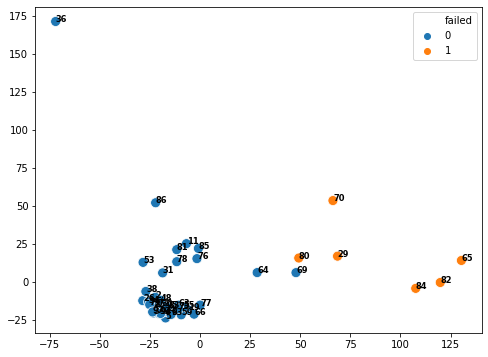

In [38]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

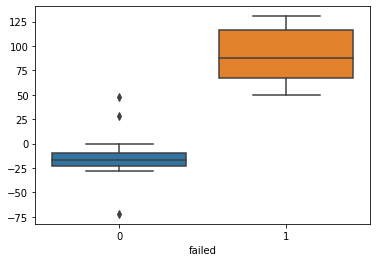

In [39]:
sns.boxplot(x =fail_df.failed, y = feat_df_pca[:,0])

In [55]:
pca.explained_variance_

array([1273.82353792,  747.15868608,  671.83837083,  645.99107311,
        554.87237012,  505.13013287,  447.59327286,  431.46161515,
        401.96141811,  361.24092063])

In [56]:
pca.singular_values_

array([231.30194247, 177.14588569, 167.97979514, 164.71680264,
       152.6585718 , 145.65529713, 137.10914434, 134.61570427,
       129.93221141, 123.17515442])

In [59]:
pc_df = pd.DataFrame(pca.components_,columns=x.columns,index = ['PC-' + str(i) for i in range(1,11)])
pc_df.head()

variable,gearbox_bearing_temperature_kurtosis__abs_energy,gearbox_bearing_temperature_kurtosis__absolute_sum_of_changes,"gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""mean""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""median""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_autocorrelation__f_agg_""var""__maxlag_40","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","gearbox_bearing_temperature_kurtosis__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,rotor_speed_std__ratio_beyond_r_sigma__r_2,rotor_speed_std__ratio_beyond_r_sigma__r_2.5,rotor_speed_std__skewness,rotor_speed_std__standard_deviation,rotor_speed_std__symmetry_looking__r_0.1,rotor_speed_std__time_reversal_asymmetry_statistic__lag_1,rotor_speed_std__time_reversal_asymmetry_statistic__lag_2,rotor_speed_std__time_reversal_asymmetry_statistic__lag_3,rotor_speed_std__variance,rotor_speed_std__variance_larger_than_standard_deviation
PC-1,-0.004362,-0.004930,0.000189,-0.000357,0.003063,-0.004543,0.004453,0.002512,-0.001695,-0.000448,...,0.013637,-0.006008,-0.008098,-0.008540,0.004053,0.008584,-0.010720,-0.005320,-0.007892,-0.005365
PC-2,0.000970,-0.002871,-0.005293,-0.009841,-0.004203,0.000052,-0.004267,-0.000921,0.004100,0.004239,...,-0.010660,-0.004739,0.000467,-0.001017,-0.002961,0.000514,0.014600,0.016229,-0.001965,-0.004791
PC-3,0.002027,0.000420,0.011593,0.004484,-0.003864,0.008800,-0.010350,-0.012056,0.001643,0.011322,...,0.007614,0.021686,0.021120,0.021753,-0.003951,0.006483,-0.001987,-0.011213,0.022437,0.023435
PC-4,0.015823,0.018505,0.010796,0.014395,-0.008660,0.017595,-0.004583,-0.008236,0.015728,0.019730,...,0.003414,0.011815,0.018779,0.018008,0.004940,0.020740,-0.002848,-0.005234,0.017889,0.016607
PC-5,-0.005024,-0.007773,0.005061,-0.003489,0.017482,0.002201,-0.011125,-0.010641,-0.004904,-0.002352,...,0.000260,0.008970,0.017417,0.012207,-0.000018,0.009534,-0.001949,-0.009233,0.012889,0.014640


#### Check: across different times

Feature Extraction: 100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


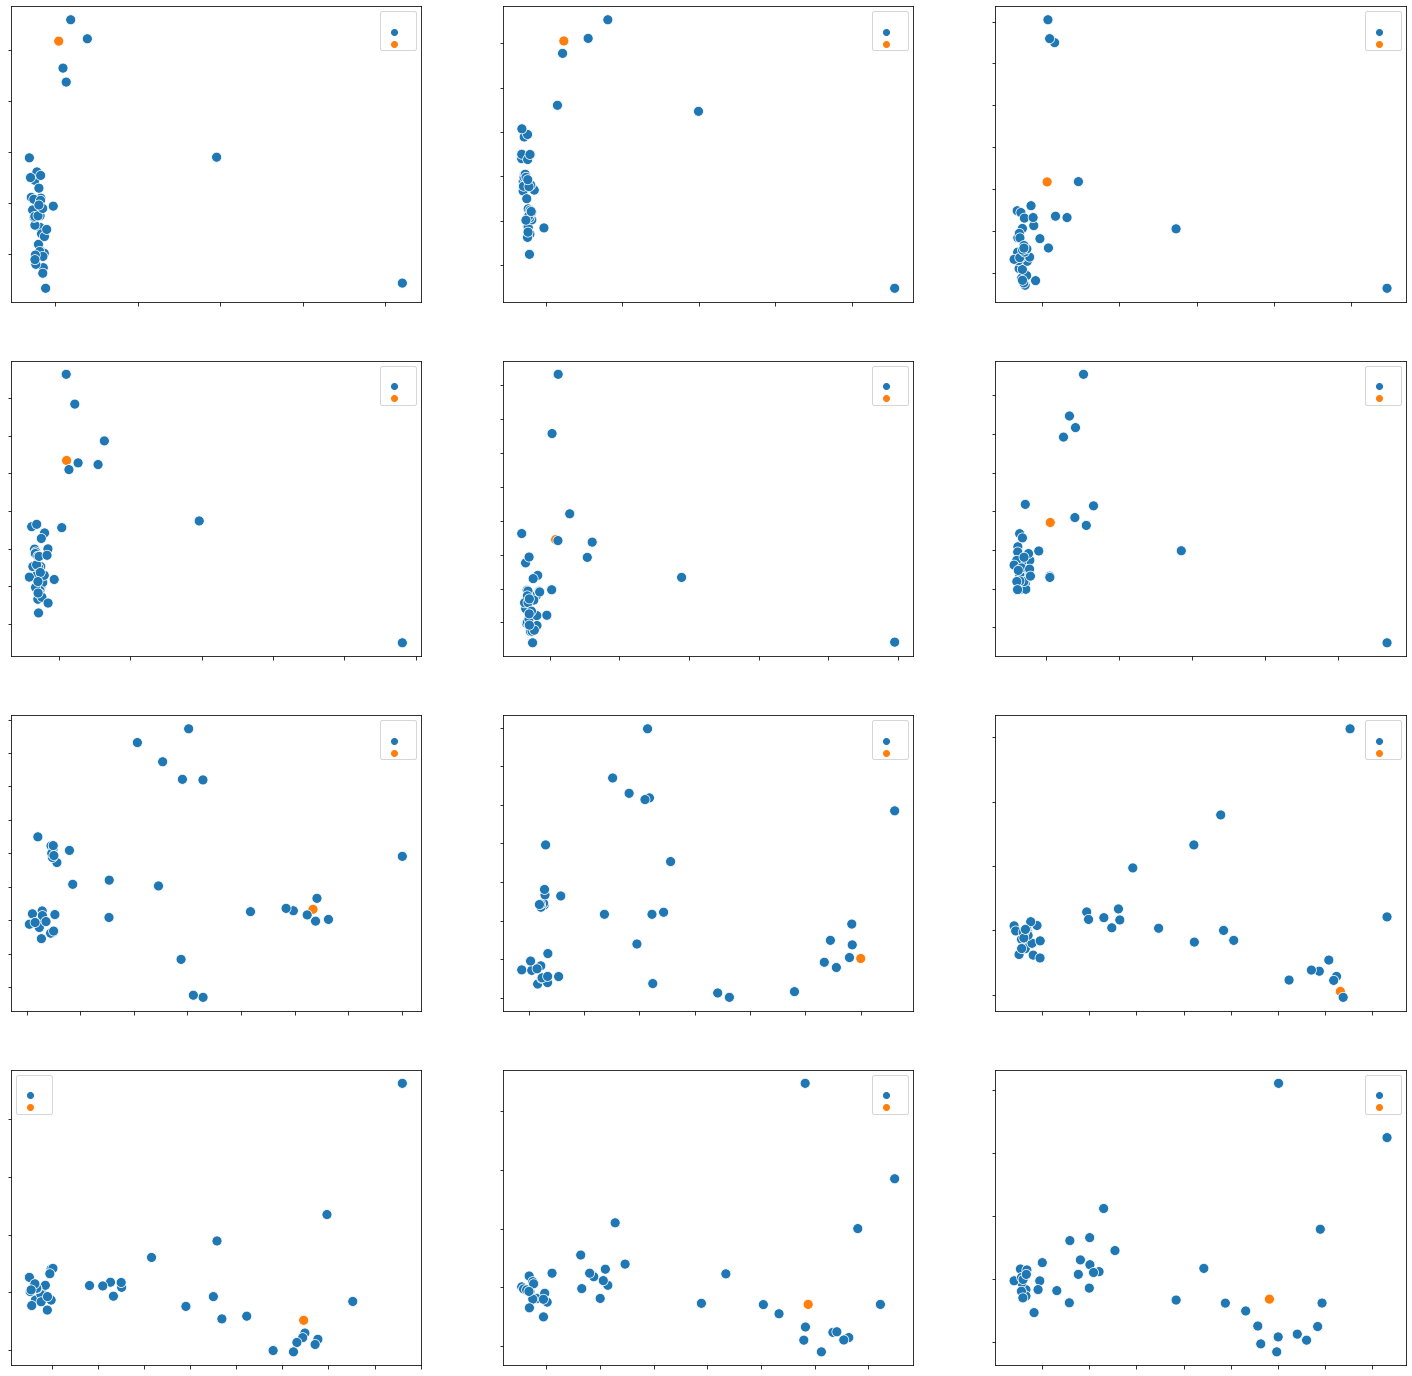

In [17]:
fig, axes = plt.subplots(figsize = (25,25), nrows = 4, ncols = 3)

ax = axes.ravel()

for p, k in enumerate([15, 30, 45, 60, 75, 90, 105, 120, 135, 150, 165, 180]):
    fail_ids = [65]
    df, fail_df = prep_df(turbine_ids=turbines, date="01-05-2011", failed_ids=fail_ids, d = k)
    feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                               default_fc_parameters= tsfeats)

    cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
    cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

    x = feat_df[cols]
    scaler = StandardScaler()
    feat_df_std = scaler.fit_transform(x)

    pca = PCA(n_components=10)
    feat_df_pca = pca.fit_transform(feat_df_std)

    sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100, ax = ax[p])

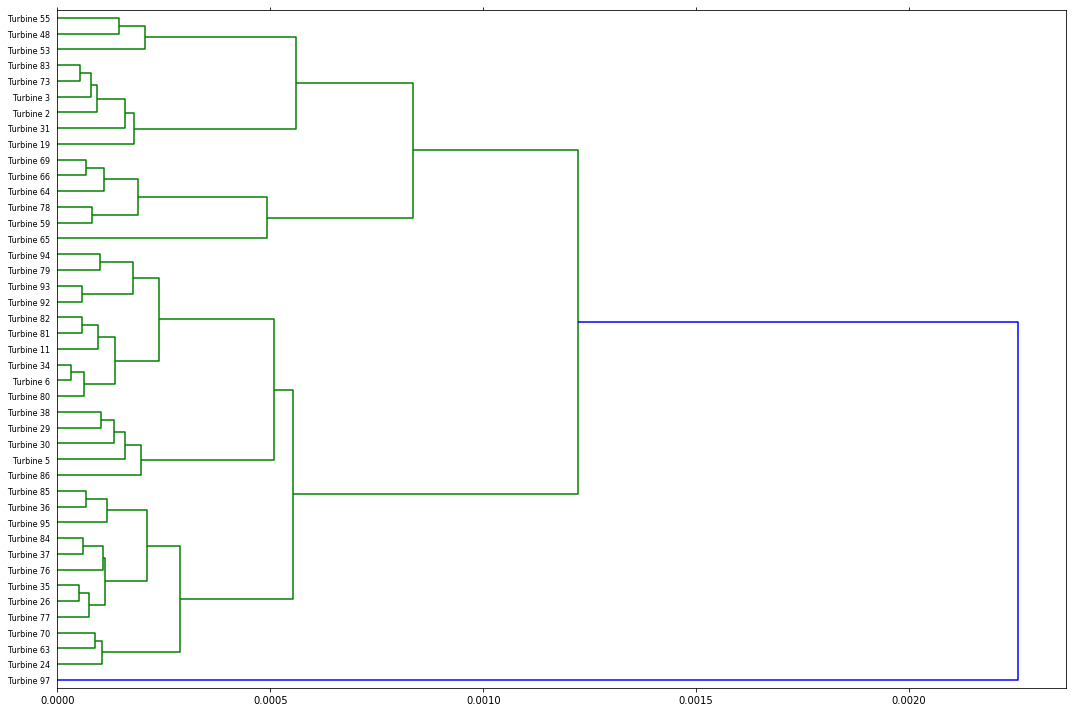

In [16]:
dist = 1 - cosine_similarity(x)

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", 
                labels=["Turbine " + str(i) for i in fail_df.turbine_id]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

Feature Extraction: 100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


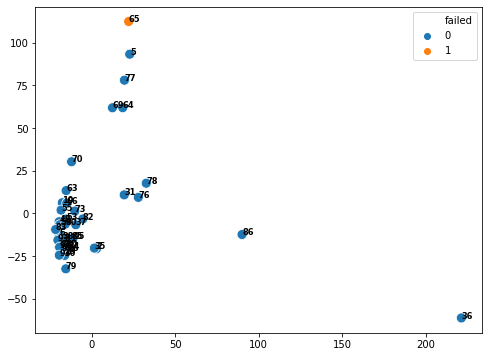

In [74]:
fail_ids = [65]
df, fail_df = prep_df(turbine_ids=turbines, date="01-04-2011", failed_ids=fail_ids)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


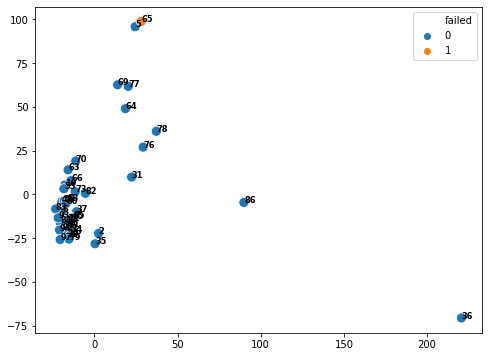

In [75]:
fail_ids = [65]
df, fail_df = prep_df(turbine_ids=turbines, date="01-03-2011", failed_ids=fail_ids)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

#### Check: All dimensions

Feature Extraction: 100%|██████████| 10/10 [00:51<00:00,  5.18s/it]


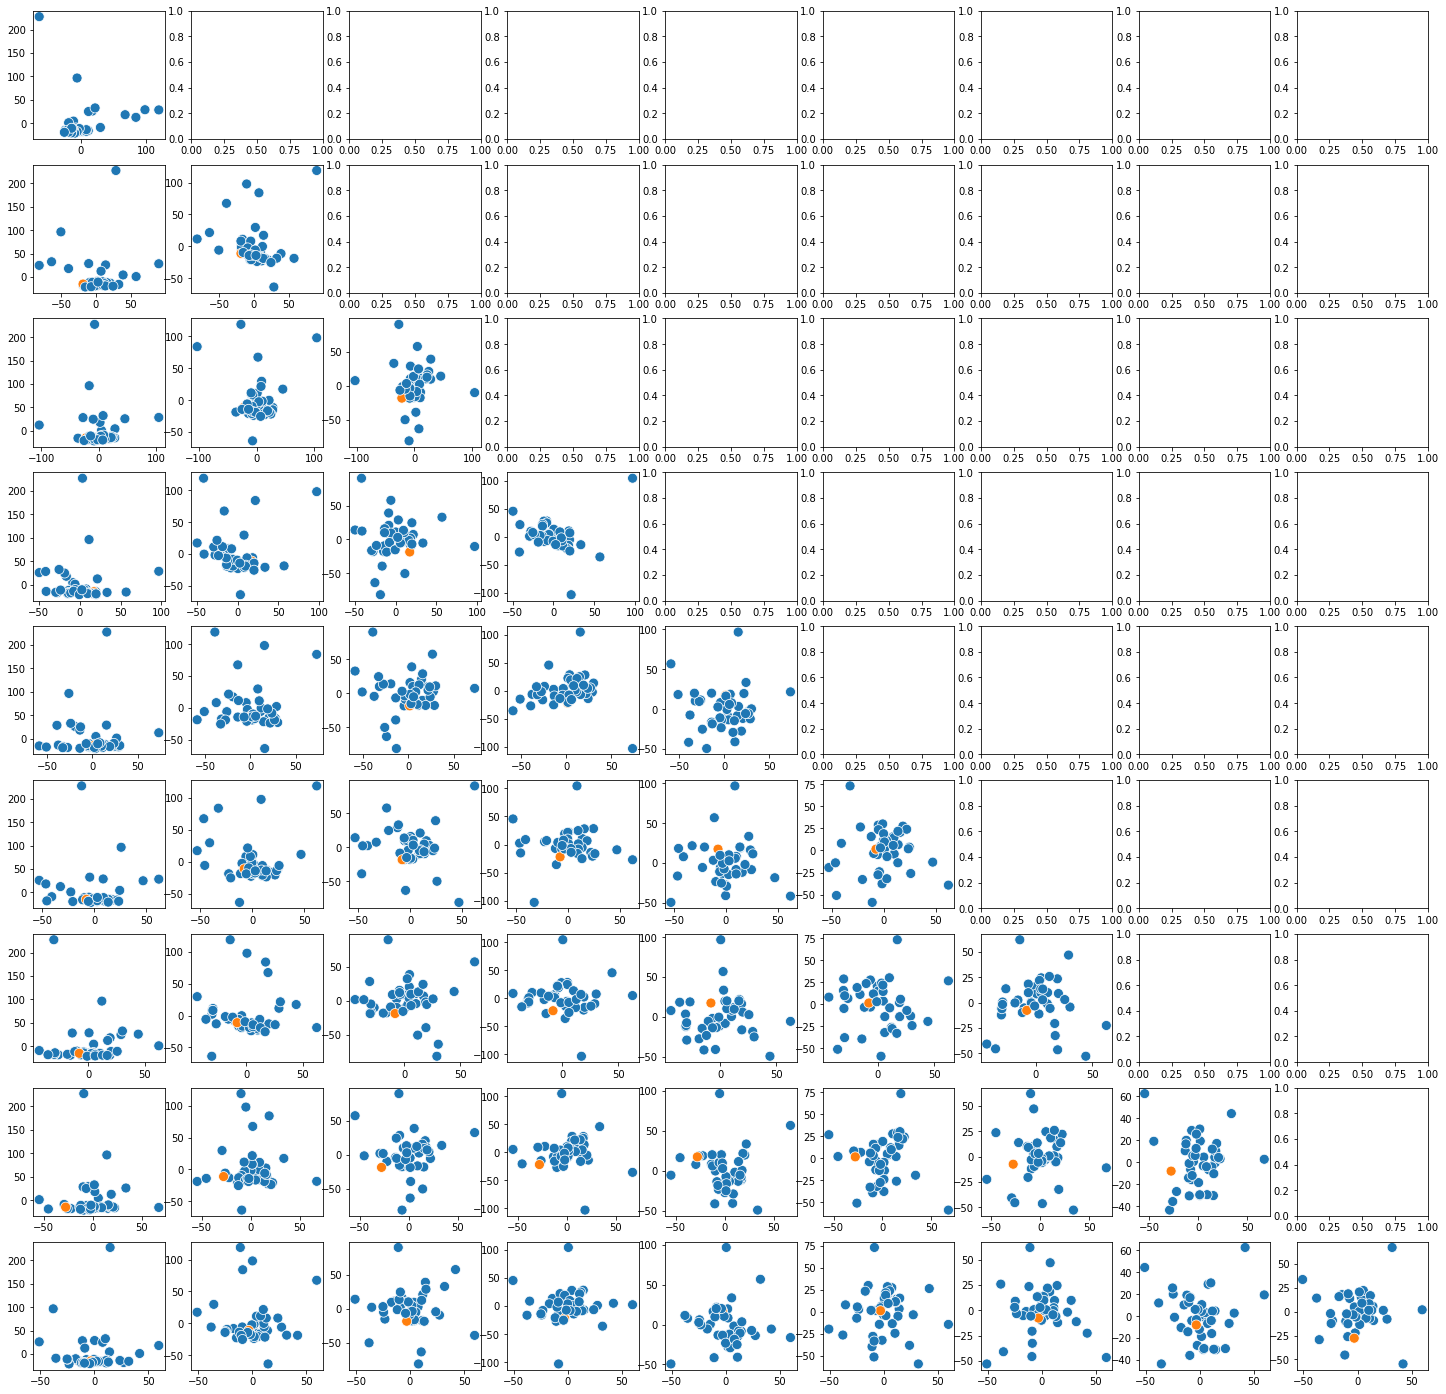

In [88]:
fail_ids = [82]
df, fail_df = prep_df(turbine_ids=turbines, date="01-01-2011", failed_ids=fail_ids)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, axes = plt.subplots(figsize = (25,25), nrows = 9, ncols = 9)

for i in range(0, 10):
    for j in range(0, i):
        if i != j:
            sns.scatterplot(x = feat_df_pca[:,i], y = feat_df_pca[:,j], hue = fail_df.failed, s = 100, ax = axes[i-1, j])
            axes[i-1, j].get_legend().remove()

#### Check: 15 days

Feature Extraction: 100%|██████████| 10/10 [00:43<00:00,  4.39s/it]


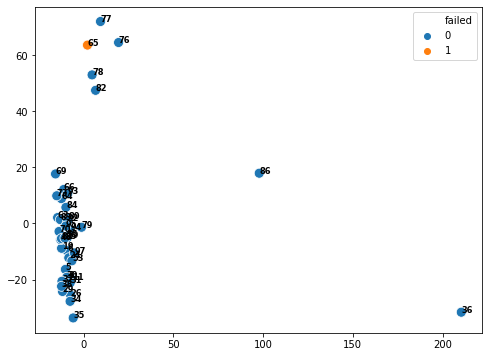

In [11]:
fail_ids = [65]
df, fail_df = prep_df(turbine_ids=turbines, date="01-05-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:41<00:00,  4.15s/it]


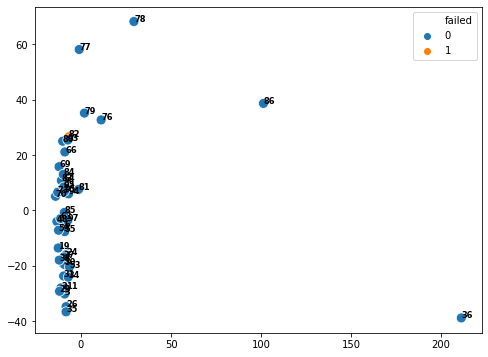

In [12]:
fail_ids = [82]
df, fail_df = prep_df(turbine_ids=turbines, date="01-01-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:41<00:00,  4.18s/it]


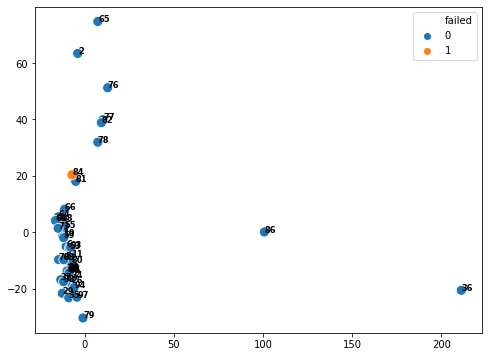

In [13]:
fail_ids = [84]
df, fail_df = prep_df(turbine_ids=turbines, date="01-08-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [01:14<00:00,  7.46s/it]


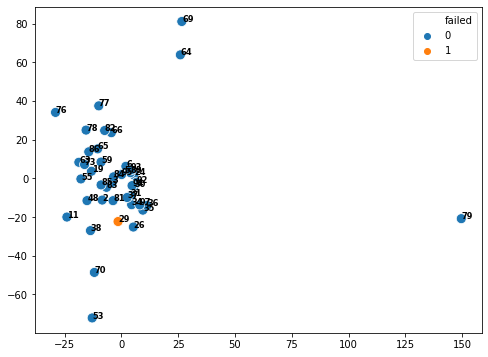

In [14]:
fail_ids = [29]
df, fail_df = prep_df(turbine_ids=turbines, date="01-13-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:43<00:00,  4.37s/it]


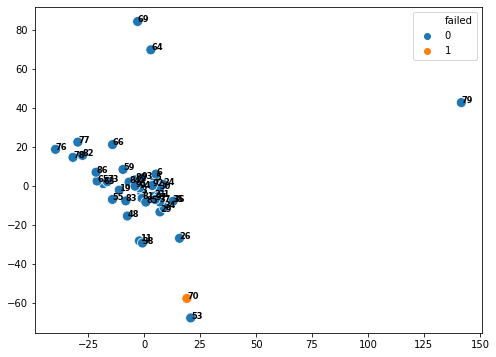

In [15]:
fail_ids = [70]
df, fail_df = prep_df(turbine_ids=turbines, date="01-14-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


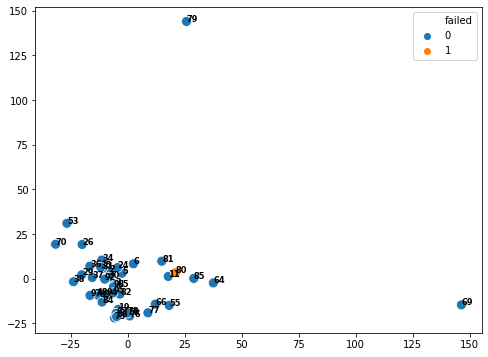

In [16]:
fail_ids = [80]
df, fail_df = prep_df(turbine_ids=turbines, date="01-21-2011", failed_ids=fail_ids, d = 15)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

#### Check: 30 days

Feature Extraction: 100%|██████████| 10/10 [01:12<00:00,  7.23s/it]


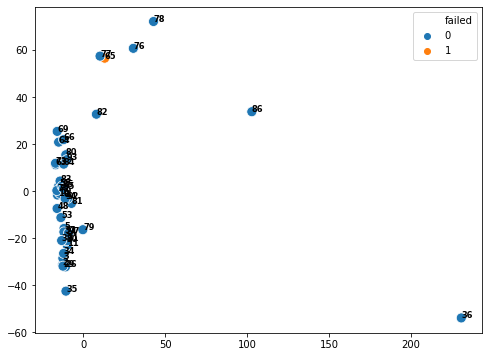

In [35]:
fail_ids = [65]
df, fail_df = prep_df(turbine_ids=turbines, date="01-05-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:57<00:00,  5.76s/it]


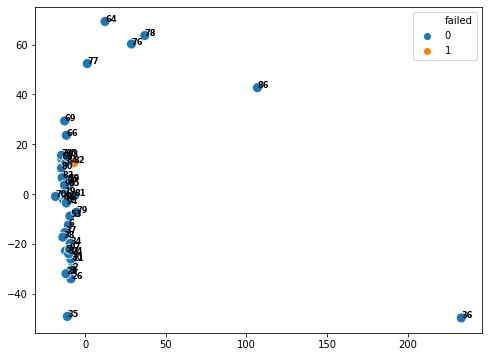

In [36]:
fail_ids = [82]
df, fail_df = prep_df(turbine_ids=turbines, date="01-01-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:54<00:00,  5.49s/it]


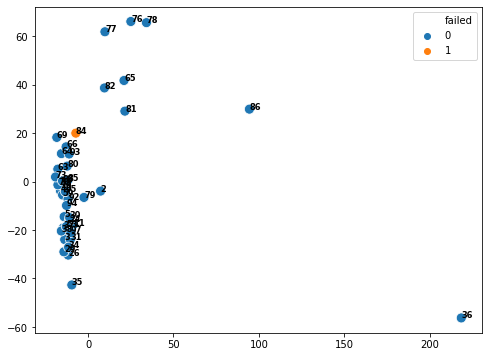

In [37]:
fail_ids = [84]
df, fail_df = prep_df(turbine_ids=turbines, date="01-08-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [00:56<00:00,  5.67s/it]


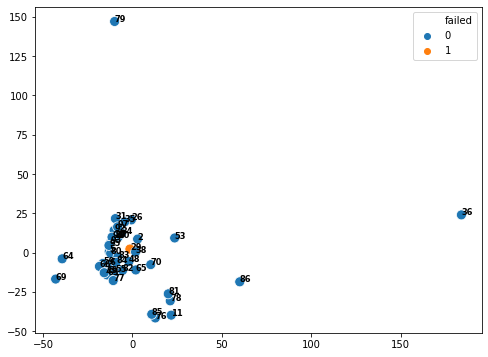

In [38]:
fail_ids = [29]
df, fail_df = prep_df(turbine_ids=turbines, date="01-13-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [01:25<00:00,  8.60s/it]


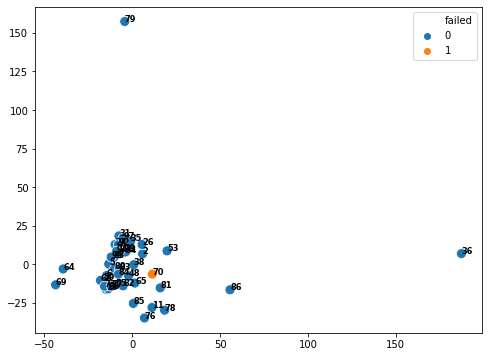

In [39]:
fail_ids = [70]
df, fail_df = prep_df(turbine_ids=turbines, date="01-14-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

Feature Extraction: 100%|██████████| 10/10 [01:05<00:00,  6.59s/it]


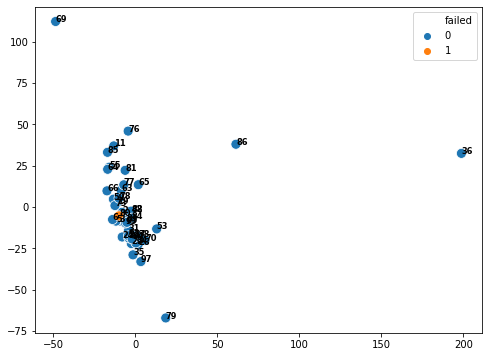

In [40]:
fail_ids = [80]
df, fail_df = prep_df(turbine_ids=turbines, date="01-21-2011", failed_ids=fail_ids, d = 30)
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

#### Failure in May-June, 2013

In [46]:
fail_ids = [11, 19, 38, 48, 66]

df, fail_df = prep_df(turbine_ids=turbines, date="06-01-2013", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3751, 36)
(43, 2)


In [47]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

Feature Extraction: 100%|██████████| 10/10 [01:41<00:00, 10.12s/it]


In [48]:
feat_df.shape

(43, 21522)

In [49]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

12184

In [50]:
x = feat_df[cols]

**Clustering using PCA**

Visualizing in first two PC components

In [51]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

In [52]:
fail_df.head()

,turbine_id,failed
0,2,0
1,3,0
2,5,0
3,6,0
4,11,1


In [53]:
feat_df_pca.shape

(43, 10)

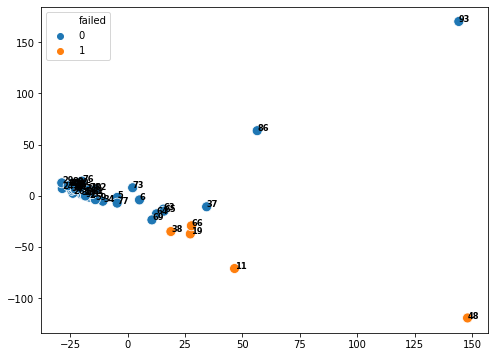

In [54]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

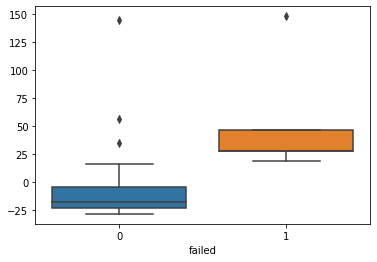

In [55]:
sns.boxplot(x =fail_df.failed, y = feat_df_pca[:,0])

In [56]:
pca.explained_variance_

array([1524.32775528, 1401.08537395, 1116.93156715,  807.80530305,
        657.92432848,  628.62201898,  484.71866306,  428.25750101,
        419.65305076,  395.12729217])

#### Failure in February, 2012

In [57]:
fail_ids = [2, 48, 79]

df, fail_df = prep_df(turbine_ids=turbines, date="03-01-2012", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3905, 36)
(43, 2)


In [58]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

Feature Extraction: 100%|██████████| 10/10 [00:58<00:00,  5.85s/it]


In [59]:
feat_df.shape

(43, 21522)

In [60]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

12634

In [61]:
x = feat_df[cols]

**Clustering using PCA**

Visualizing in first two PC components

In [62]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

In [63]:
fail_df.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,0


In [64]:
feat_df_pca.shape

(43, 10)

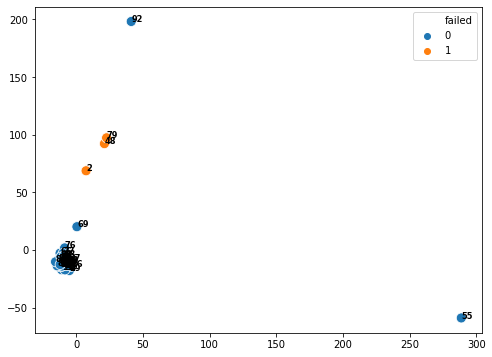

In [65]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

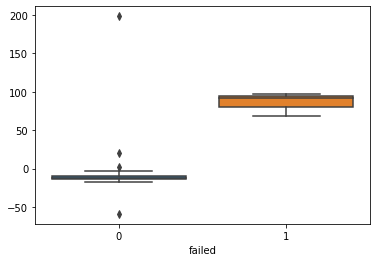

In [66]:
sns.boxplot(x =fail_df.failed, y = feat_df_pca[:,1])

In [67]:
pca.explained_variance_

array([2149.92517906, 1693.63712757, 1283.51834896,  923.73613533,
        702.19691968,  563.31948517,  493.42826284,  425.91838982,
        338.00042424,  302.56368288])

#### Considering all turbines

In [315]:
df, fail_df = prep_df(turbine_ids=turbines, date="02-01-2012", failed_ids=failed)

print(df.shape)
print(fail_df.shape)

(3841, 32)
(43, 2)


In [316]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)


Feature Extraction: 100%|██████████| 10/10 [00:44<00:00,  4.44s/it]


In [317]:
feat_df.shape

(43, 18990)

In [318]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

11020

In [319]:
x = feat_df[cols]

**Clustering using PCA**

Visualizing in first two PC components

In [320]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

In [321]:
fail_df.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,1


In [322]:
feat_df_pca.shape

(43, 10)

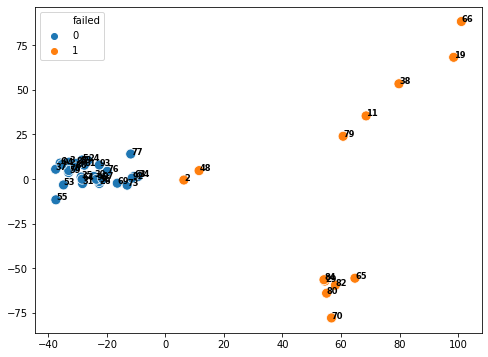

In [323]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

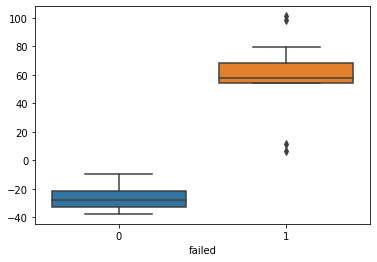

In [324]:
sns.boxplot(x =fail_df.failed, y = feat_df_pca[:,0])

In [325]:
pca.explained_variance_

array([1818.86850838,  992.09529059,  599.77284874,  511.16919215,
        498.95946937,  398.28871905,  379.61706987,  369.00531562,
        337.19917713,  334.05501433])

In [326]:
df, fail_df = prep_df(turbine_ids=turbines, date="06-01-2013", failed_ids=failed)

print(df.shape)
print(fail_df.shape)

(3716, 32)
(43, 2)


In [327]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)


Feature Extraction: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]


In [328]:
feat_df.shape

(43, 18990)

In [329]:
# drop columns that do not have any variance
cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
# drop columns that contain nan
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

len(cols)

10420

In [330]:
x = feat_df[cols]

**Clustering using PCA**

Visualizing in first two PC components

In [331]:
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

In [332]:
fail_df.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,1


In [333]:
feat_df_pca.shape

(43, 10)

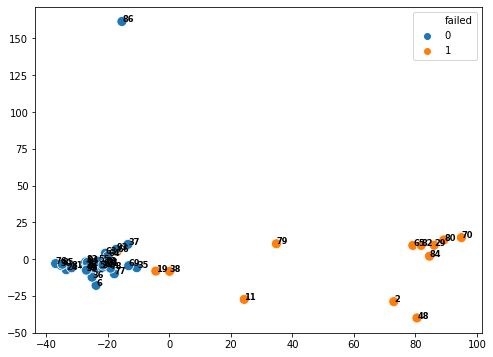

In [334]:
fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

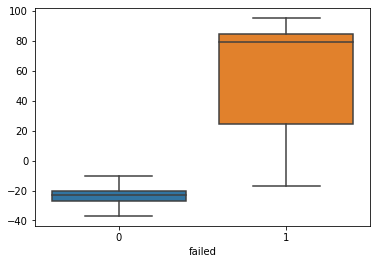

In [335]:
sns.boxplot(x =fail_df.failed, y = feat_df_pca[:,0])

In [336]:
pca.explained_variance_

array([1818.78519719,  750.2672419 ,  700.45750583,  544.36754816,
        456.7004299 ,  381.46293335,  370.67994064,  333.12266529,
        323.0953534 ,  304.24693548])

## Visualizaing across different times

In [353]:
def prep_df2(turbine_ids, date, failed_ids):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        
        last_date = pd.to_datetime(date)
        temp_df = temp_df[temp_df.Date <= last_date] #"10-01-2013"
            
        if i in failed_ids:
            failure = failure.append({'turbine_id': i, 'failed':1}, True)
        else: 
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    failure = failure.sort_values('turbine_id').reset_index(drop = True)
    df.dropna(inplace = True)
    return df, failure

In [354]:
# ids of failed turbines
hss_a = [2, 29, 65, 70, 84]
hss_b = [19, 38, 65, 82]
ims_a = [65]
ims_b = [11, 48, 65, 66, 79, 80]

failed = list(np.unique(hss_a + hss_b + ims_a + ims_b))

# ids of healthy turbines
healthy = [3, 5, 6, 24, 26, 30, 31, 34, 35, 36, 37, 53, 55, 59, 63, 64, 69, 73, 76, 77, 78, 81, 83,\
          85, 86, 92, 93, 94, 95, 97]

turbines = failed + healthy

In [355]:
df, failure_df = prep_df2(turbines, date = "01-01-2014", failed_ids=failed)
print(df.shape)
print(failure_df.shape)

(76746, 32)
(43, 2)


In [357]:
df.head()

,turbine_id,Date,power_mean,power_std,power_min,power_max,power_rms,power_kurtosis,rotor_speed_mean,rotor_speed_std,...,gearbox_bearing_temperature_min,gearbox_bearing_temperature_max,gearbox_bearing_temperature_rms,gearbox_bearing_temperature_kurtosis,nacelle_temperature_mean,nacelle_temperature_std,nacelle_temperature_min,nacelle_temperature_max,nacelle_temperature_rms,nacelle_temperature_kurtosis
0,2,2008-12-01,619.066702,395.056823,-5.231667,1515.18665,78.602709,2.424308,15.721165,3.332425,...,29.000000,61.000000,6.203714,17.751497,14.151552,2.976744,10.175000,22.000000,1.550030,3.279908
2,2,2008-12-03,1484.094842,114.619552,988.966675,1530.72839,324.774613,18.289232,18.163873,0.942526,...,40.123333,61.818333,13.075673,15.122029,16.007857,1.701399,12.910000,18.200001,3.511942,1.987490
3,2,2008-12-04,537.489006,329.205906,84.135002,1386.19495,55.011703,2.264321,15.592327,2.644072,...,54.003334,60.490002,5.077943,1.863888,8.803779,3.734821,3.123333,18.756666,0.835057,2.880624
4,2,2008-12-05,238.391666,346.931946,-10.133333,1483.44995,42.590294,5.723599,9.626430,6.653666,...,32.000000,61.000000,5.122467,1.956948,9.509656,4.017372,2.000000,16.000000,1.047365,1.970233
6,2,2008-12-07,1215.260703,375.512536,405.088348,1531.02002,107.466308,2.117664,18.135503,0.523370,...,58.806667,62.000000,5.173721,3.147123,19.144952,2.727475,14.731667,23.863333,1.634265,1.691391


In [356]:
failure_df.head()

,turbine_id,failed
0,2,1
1,3,0
2,5,0
3,6,0
4,11,1


In [360]:
import logging
logger = logging.getLogger() 
logger.setLevel(logging.CRITICAL)




Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]


Feature Extraction:  10%|█         | 1/10 [00:10<01:34, 10.49s/it]


Feature Extraction:  20%|██        | 2/10 [00:10<00:59,  7.43s/it]


Feature Extraction:  30%|███       | 3/10 [00:19<00:53,  7.70s/it]


Feature Extraction:  40%|████      | 4/10 [00:19<00:32,  5.48s/it]


Feature Extraction:  50%|█████     | 5/10 [00:28<00:32,  6.42s/it]


Feature Extraction:  60%|██████    | 6/10 [00:28<00:18,  4.59s/it]


Feature Extraction:  70%|███████   | 7/10 [00:37<00:17,  5.83s/it]


Feature Extraction:  80%|████████  | 8/10 [00:37<00:08,  4.15s/it]


Feature Extraction:  90%|█████████ | 9/10 [00:45<00:05,  5.38s/it]


Feature Extraction: 100%|██████████| 10/10 [00:45<00:00,  4.57s/it]



Feature Extraction:   0%|          | 0/10 [00:00<?, ?it/s]


Feature Extraction:  10%|█         | 1/10 [00:08<01:20,  8.96s/it]


Feature Extraction:  20%|██        | 2/10 [00:09<00:50,  6.37s/it]


Feature Extraction:  30%|███       | 3/10 [00

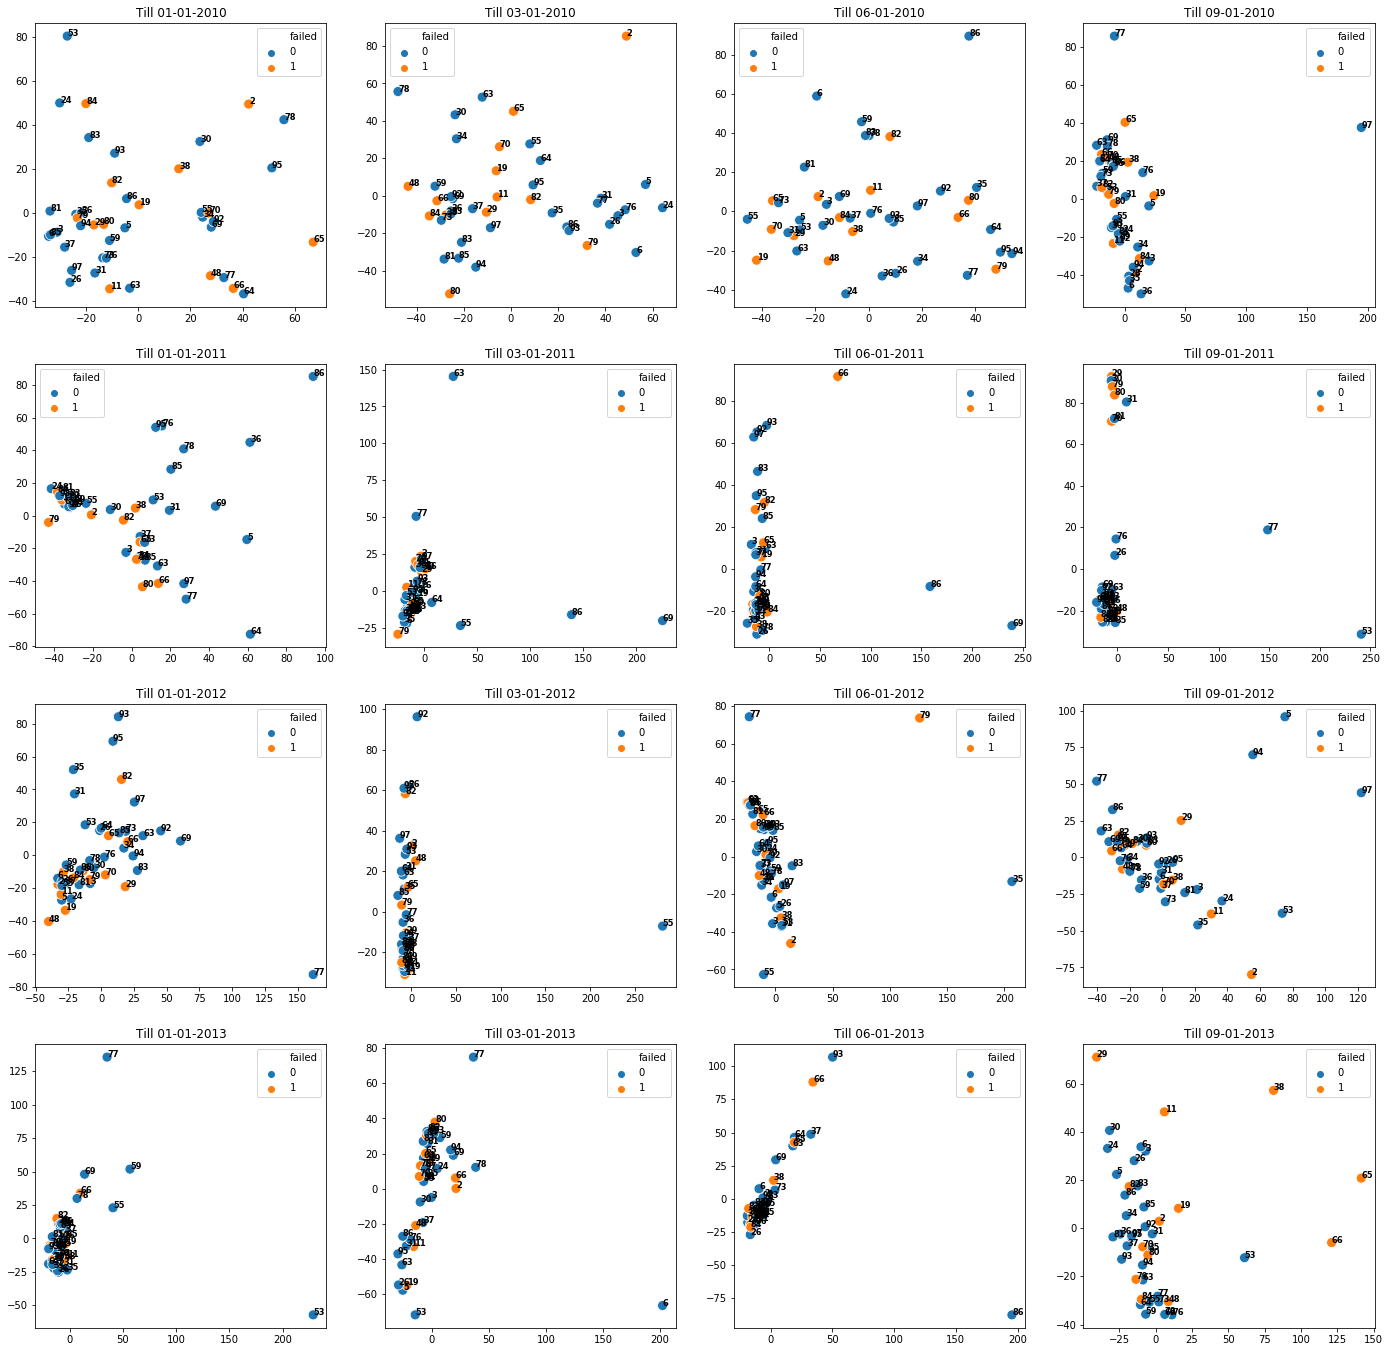

In [364]:
fig, axes = plt.subplots(figsize = (24,24), nrows= 4, ncols = 4)

ax = axes.ravel()

dates = ["01-01-2010", "03-01-2010", "06-01-2010", "09-01-2010",
         "01-01-2011", "03-01-2011", "06-01-2011", "09-01-2011",
         "01-01-2012", "03-01-2012", "06-01-2012", "09-01-2012",
         "01-01-2013", "03-01-2013", "06-01-2013", "09-01-2013"]

for i, date in enumerate(dates):
    
    last_date = pd.to_datetime(date)
    start_date = last_date - pd.to_timedelta(90, unit='d')
    
    temp_df = df[(df.Date >= start_date) & (df.Date <= last_date)]
    temp_feat_df = extract_features(temp_df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)
    cols = temp_feat_df.columns.drop(temp_feat_df.columns[temp_feat_df.var() == 0])
    cols = cols.drop(temp_feat_df[cols].columns[temp_feat_df[cols].isnull().sum() > 0])
    x = temp_feat_df[cols]
    
    scaler = StandardScaler()
    feat_df_std = scaler.fit_transform(x)
    pca = PCA(n_components=10)
    feat_df_pca = pca.fit_transform(feat_df_std)
    
    sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = failure_df.failed, s = 100, ax = ax[i])
    ax[i].set_title("Till " + date)
    
    for line in range(0,feat_df_pca.shape[0]):
        ax[i].text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
            failure_df.turbine_id[line], horizontalalignment='left', 
            size='small', color='black', weight='semibold')
    
    extent = ax[i].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(date + '.png', bbox_inches=extent.expanded(1.1, 1.2))

## Randomly Selecting date for healthy turbines

In [20]:
def prep_df2(turbine_ids, date, failed_ids, d = 90):
    
    failure = pd.DataFrame(columns = ['turbine_id', 'failed'])
    df = pd.DataFrame()

    for i in turbine_ids:
        temp_df = feather.read_dataframe(glob.glob("Datafeathers/running/*_" + str(i) + "_*.feather")[0])
        temp_df.time = pd.to_datetime(temp_df.time)
        temp_df["Date"] = temp_df.time.dt.date
        
        shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
        
        shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
        
        if i in failed_ids:
            
            shutdowns = list(failures['Shutdown.Date'][failures.ID == i])
            shutdown_date = pd.to_datetime(failures['Shutdown.Date'][failures.ID == i].iloc[0])
            
            if(pd.notnull(shutdown_date)):
                temp_df = temp_df[temp_df.Date <= shutdown_date]
                start_date = shutdown_date - pd.to_timedelta(d, unit='d')
                temp_df = temp_df[temp_df.Date >= start_date]
                failure = failure.append({'turbine_id': i, 'failed':1}, True)
        
        else: 
            
            random_day = random.choice(range(-10,10))
            last_date = pd.to_datetime(date) + pd.to_timedelta(random_day, unit='d')
            temp_df = temp_df[temp_df.Date <= last_date] 
            start_date = last_date - pd.to_timedelta(d, unit='d')
            temp_df = temp_df[temp_df.Date >= start_date]
            failure = failure.append({'turbine_id': i, 'failed':0}, True)
            
        df = df.append(temp_df)

    df = df.reset_index(drop = True)

    df.drop(['wind_direction_10_sec', 'wind_direction_1_sec', 'stateFault', 'wind_speed', 'ambient_temperature'],\
            axis = 1, inplace = True)
    
    df = df.groupby(['turbine_id', 'Date']).agg(agg_dict)
    df.columns = ['_'.join(x) if isinstance(x,tuple) else x for x in df.columns.ravel()]
    df = df.reset_index()
    
    df['power_EI'] = df.power_rms/df.groupby('turbine_id').power_rms.transform('mean')
    df['gearbox_bearing_temperature_EI'] = df.gearbox_bearing_temperature_rms/df.groupby('turbine_id').gearbox_bearing_temperature_rms.transform('mean')
    df['gearbox_oil_temperature_EI'] = df.gearbox_oil_temperature_rms/df.groupby('turbine_id').gearbox_oil_temperature_rms.transform('mean')
    df['nacelle_temperature_EI'] = df.nacelle_temperature_rms/df.groupby('turbine_id').nacelle_temperature_rms.transform('mean')
    df['rotor_speed_EI'] = df.rotor_speed_rms/df.groupby('turbine_id').rotor_speed_rms.transform('mean')

    failure = failure.sort_values('turbine_id').reset_index(drop = True)
    df.dropna(inplace = True)
    return df, failure

#### Failure in January, 2011

In [41]:
fail_ids = [29, 65, 70, 80, 82, 84]

df, fail_df = prep_df2(turbine_ids=turbines, date="01-11-2011", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3900, 42)
(43, 2)


Feature Extraction: 100%|██████████| 10/10 [01:15<00:00,  7.50s/it]


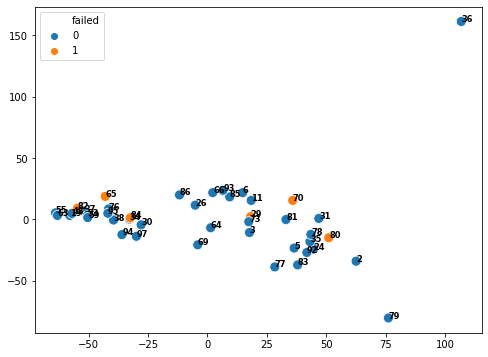

In [42]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

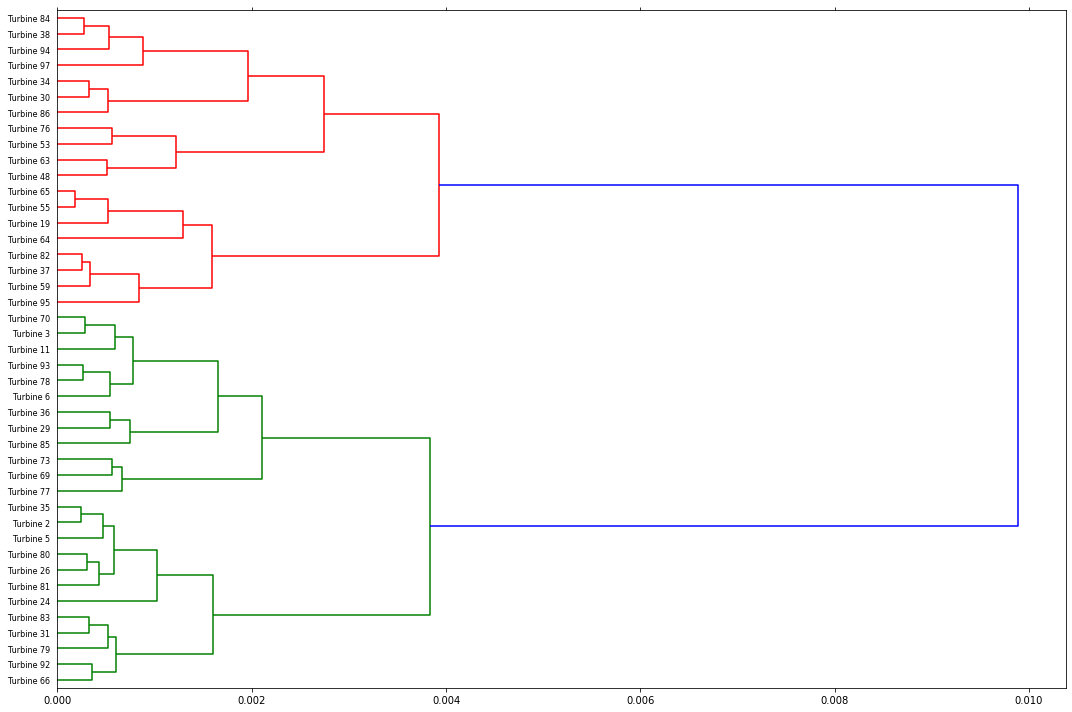

In [43]:
dist = 1 - cosine_similarity(x)

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", 
                labels=["Turbine " + str(i) for i in fail_df.turbine_id]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Failure in May-June, 2013

In [44]:
fail_ids = [11, 19, 38, 48, 66]

df, fail_df = prep_df2(turbine_ids=turbines, date="06-01-2013", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3751, 42)
(43, 2)


Feature Extraction: 100%|██████████| 10/10 [01:29<00:00,  8.91s/it]


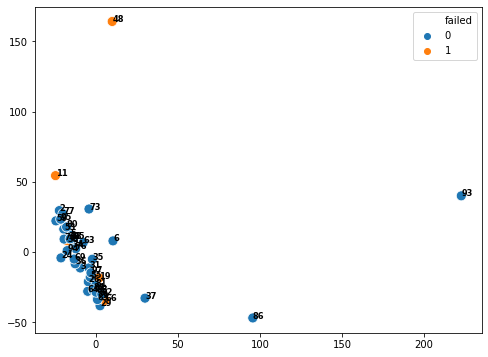

In [45]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

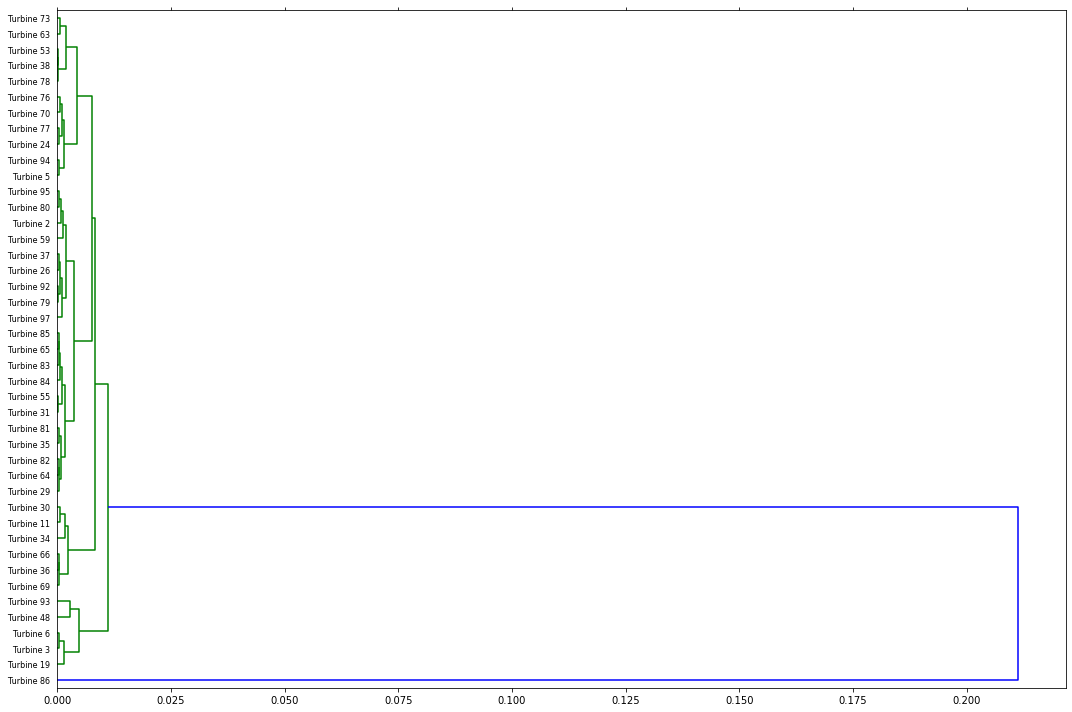

In [46]:
dist = 1 - cosine_similarity(x)

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", 
                labels=["Turbine " + str(i) for i in fail_df.turbine_id]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()

#### Failure in February, 2012

In [47]:
fail_ids = [2, 48, 79]

df, fail_df = prep_df2(turbine_ids=turbines, date="03-15-2012", failed_ids=fail_ids)

print(df.shape)
print(fail_df.shape)

(3905, 42)
(43, 2)


Feature Extraction: 100%|██████████| 10/10 [01:30<00:00,  9.05s/it]


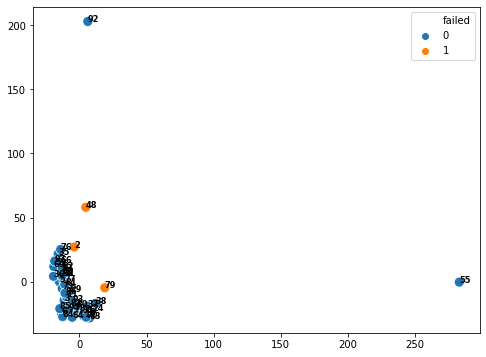

In [48]:
feat_df = extract_features(df, column_id="turbine_id", column_sort="Date", \
                           default_fc_parameters= tsfeats)

cols = feat_df.columns.drop(feat_df.columns[feat_df.var() == 0])
cols = cols.drop(feat_df[cols].columns[feat_df[cols].isnull().sum() > 0])

x = feat_df[cols]
scaler = StandardScaler()
feat_df_std = scaler.fit_transform(x)

pca = PCA(n_components=10)
feat_df_pca = pca.fit_transform(feat_df_std)

fig, ax = plt.subplots(figsize = (8,6))
p1 = sns.scatterplot(x = feat_df_pca[:,0], y = feat_df_pca[:,1], hue = fail_df.failed, s = 100)

for line in range(0,feat_df_pca.shape[0]):
    p1.text(feat_df_pca[line, 0]+0.1, feat_df_pca[line, 1], 
        fail_df.turbine_id[line], horizontalalignment='left', 
        size='small', color='black', weight='semibold')

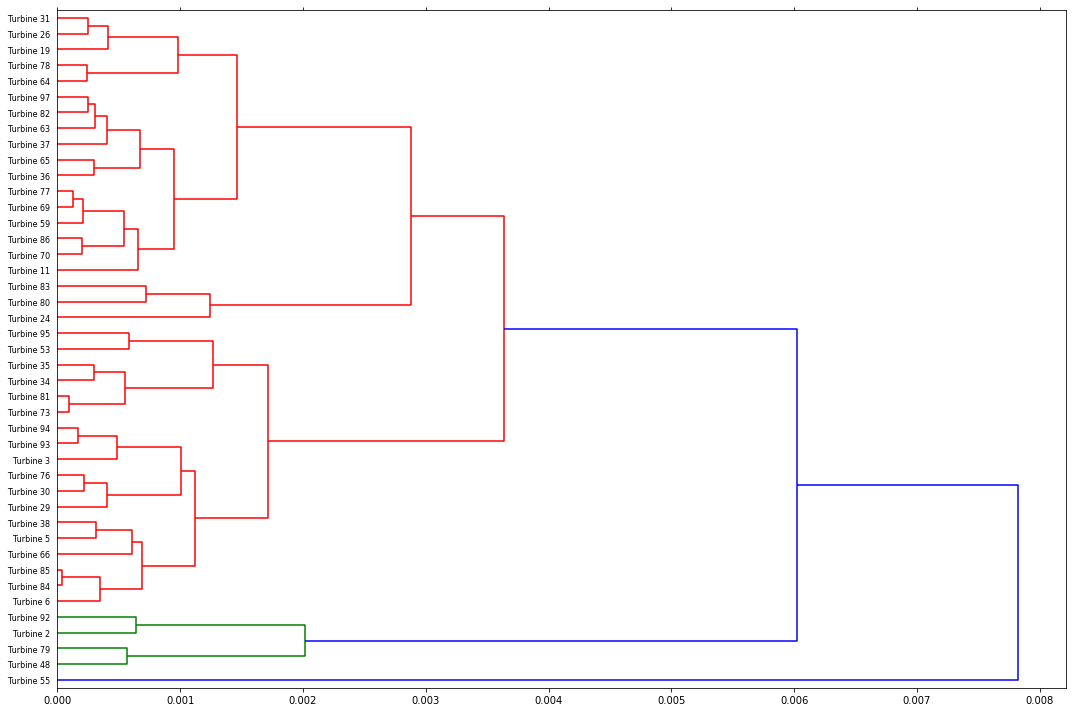

In [49]:
dist = 1 - cosine_similarity(x)

linkage_matrix = ward(dist)

fig, ax = plt.subplots(figsize=(15, 10))
ax = dendrogram(linkage_matrix, orientation="right", 
                labels=["Turbine " + str(i) for i in fail_df.turbine_id]);

plt.tick_params(axis= 'x',  which='both', bottom='off', top='off', labelbottom='off')

plt.tight_layout()